# Github statistics API

    >>> import __Github_Statistics as ghstats
    >>> assert isinstance(ghstats.main('bokeh/bokeh'), DataFrame)

## Waiting for statistics to compute

http://developer.github.com/v3/repos/statistics/

In [1]:
    from pandas import DataFrame, Series, to_datetime, concat
    import requests, shelve, time
    from matplotlib.pyplot import gca, gcf
    from IPython import get_ipython

## The 202 request

In [2]:
    def get_202(url: str) -> object:
        """Requests a url that may need to compute a result. Cache the results on disk in shelve.

        > get_202("https://api.github.com/repos/pandas-dev/pandas/stats/commit_activity")
        > get_202("https://api.github.com/repos/pandas-dev/pandas/stats/code_frequency")
        """
        with shelve.open('activity') as db:
            if url not in db:
                response = requests.get(url)
                if response.status_code == 202:
                    return time.sleep(2) or get_202(url)

                db[url] = response.json()

            return db[url]

Interactively develop this project using pandas as an example.

In [3]:
    project='pandas-dev/pandas'; project

'pandas-dev/pandas'

# Commit activity.

In [4]:
    DAYS = "Sun Mon Tues Wed Thu Fri Sat".split()

Tidy the daily commit activity.

In [5]:
    def format_weekly_commits(value):
        return DataFrame(value).pipe(
            lambda df: DataFrame(
                df.days.apply(Series).values, columns=DAYS, index=to_datetime(df.week, unit='s')))

In [6]:
    def get_weekly_commits(project=project):
        return format_weekly_commits(
            get_202(f'https://api.github.com/repos/{project}/stats/commit_activity'))

## Code Frequency

Code frequency is the number of weekly additions and subtractions of code to a projects. 

In [7]:
    def format_weekly_frequency(value):
        df = DataFrame(value, columns="week + -".split())
        df['week'] = to_datetime(df['week'], unit='s')
        return df.set_index('week').set_index('+ -'.split(), append=True)

In [8]:
    def get_weekly_frequency(project=project):
        return format_weekly_frequency(
            get_202(f'https://api.github.com/repos/{project}/stats/code_frequency'))

### Combine the commits with 

In [9]:
    def get_one(project=project):
        df = get_weekly_commits(project)
        return df.join(get_weekly_frequency(project))

# The _main_ weekly dataframe



    >>> main('pandas-dev/pandas')

In [10]:
    def main(*projects):
        """Get the weekly commit"""
        return concat({object: get_one(object) for object in projects})

In [11]:
    if __name__ == '__main__':
        %matplotlib inline
        df = main(project, 'bokeh/bokeh')
        df = df.apply(Series.describe, axis=1)
        

Visualize the code additions and subtractions over the past ~1year.

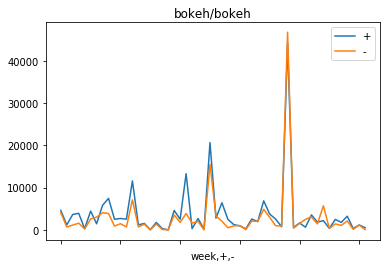

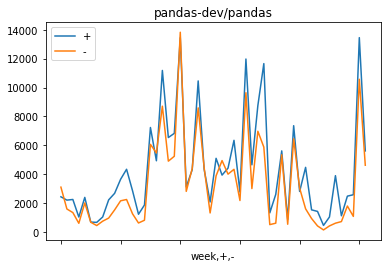

In [12]:
    # NBVAL_IGNORE_OUTPUT
    if __name__ == '__main__':
        for project in df.index.get_level_values(0).unique():
            df.loc[project].index.to_frame()['+ -'.split()].abs().plot()
            gca().set_title(project);

### [Developer] Test the module.

In [13]:
    if __name__ == '__main__':
        from deathbeds import _018_06_19_Github_Statistics
        __import__('doctest').testmod(_018_06_19_Github_Statistics), print("🤑🤑🤑")

🤑🤑🤑
